# LIBRARIES

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns
plt.rcParams.update({'font.size':18})

# For timing computations
import time

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_26332/1603149711.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## WINE DATASET

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
# Remove rows with outliers
data = data[data['total sulfur dioxide']<200]

# Z-SCORE ALL VARIABLES EXCEPT FOR QUALITY
# Find the columns we want to normalize (all except quality)
cols_2_zscore = data.keys()
cols_2_zscore = cols_2_zscore.drop('quality')
data[cols_2_zscore] = data[cols_2_zscore].apply(stats.zscore)

qual_threshold = 5
# Create a new column for binarized (boolean) quality
temp = (data['quality'] > qual_threshold).astype(int)
data['boolQuality'] = temp

# SEPARATE THE DATA INTO BATCHES

In [3]:
# Convert from pandas dataframe to tensor
dataT  = torch.tensor(data=data[cols_2_zscore].values).float()
labels = torch.tensor(data=data['boolQuality'].values).float()
labels = labels[:, None] # Transform to matrix. We'll actually need the labels to be a "tensor"

# print(dataT.shape)
# print(labels.shape)

In [4]:
# Separate the data into DataLoaders
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=0.1)

# Then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

# Finally, translate into dataloader objects
train_batch_size = 64
test_batch_size  = test_dataset.tensors[0].shape[0]
train_loader     = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True)
test_loader      = DataLoader(dataset=test_dataset, batch_size=test_batch_size)

# Now for the DL part

In [5]:
class ANN_wine(nn.Module):
  """
  ANN_wine + Activation Function
  """
  def __init__(self, act_func):
    super().__init__()

    # LAYERS
    # Input layer
    self.input = nn.Linear(11, 16)

    # Hidden layer(s). 'fc' = fully connected
    self.fc1 = nn.Linear(16, 32)
    self.fc2 = nn.Linear(32, 32)

    # Output layer
    self.output = nn.Linear(32, 1)

    # Activation funcion to pass through
    self.act_func = act_func
  
  # Forward pass
  def forward(self, x):
    # Get activation function type, this code replaces torch.relu with torch.<self.actfun>
    act_func = getattr(torch.nn, self.act_func)
    x = act_func()(self.input(x))
    x = act_func()(self.fc1(x))
    x = act_func()(self.fc2(x))
    x = self.output(x)

    return x

# Train the model

In [6]:
# Global parameter
num_epochs = 1000

def train_the_model():
  """
  Create model included
  """

  loss_func = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(wine_net.parameters(), lr=0.001)

  # Initialize accuracies as empties
  train_acc = []
  test_acc  = []
  losses = torch.zeros(num_epochs)

  # Loop over epochs
  for epoch_i in range(num_epochs):
    # Activate training mode
    wine_net.train()

    # Loop over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # Forward pass and loss
      y_hat = wine_net(X)
      loss  = loss_func(y_hat, y)

      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Compute training accuracy just for this batch
      batch_acc.append(100 * torch.mean(((y_hat > 0) == y).float()).item())

      # Loss from this batch
      batch_loss.append(loss.item())

    # End of batch loop...

    # Now that we've trained through the batches, get their average training accuracy 
    train_acc.append(np.mean(batch_acc))

    # Get average losses across the batches
    losses[epoch_i] = np.mean(batch_loss)

    # Test accuracy (NOTE: testing in batches!)    
    X, y = next(iter(test_loader))  # Extract x,y from test dataloader
    wine_net.eval()                 # Activate testing mode
    with torch.no_grad():           # Deactivates autograd
      # pred_labels = torch.argmax(wine_net(X), axis=1)
      pred_labels = wine_net(X)

    # Compute accuracy
    test_acc.append(100 * torch.mean(((pred_labels > 0) == y).float()).item())

  # Function output
  return train_acc, test_acc, losses

In [7]:
# List activation functions to test
activation_funcs = ['ReLU', 'ReLU6', 'LeakyReLU']

train_acc_by_act = np.zeros(shape=(num_epochs, len(activation_funcs)))
test_acc_by_act  = np.zeros(shape=(num_epochs, len(activation_funcs)))

for i, act_func_i in enumerate(activation_funcs):
  # Create a model and train it
  wine_net = ANN_wine(act_func=act_func_i)
  train_acc_by_act[:, i], test_acc_by_act[:, i], losses = train_the_model()

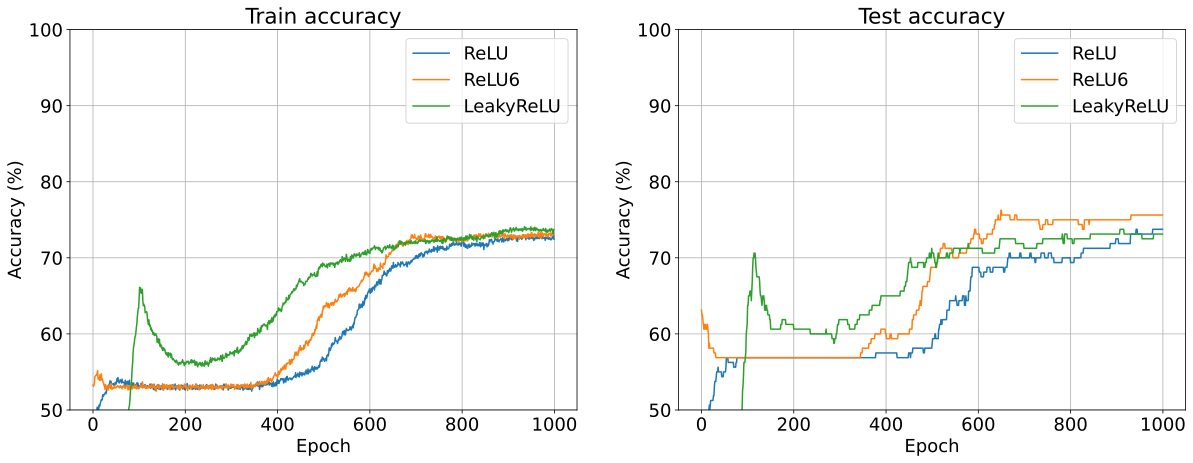

In [8]:
fig, ax = plt.subplots(1 ,2, figsize=(20,7))

ax[0].plot(train_acc_by_act)
ax[0].set_title('Train accuracy')
ax[1].plot(test_acc_by_act)
ax[1].set_title('Test accuracy')

# Common features
for i in range(2):
  ax[i].legend(activation_funcs)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50, 100])
  ax[i].grid()

plt.show()

# Additional explorations

In [9]:
# This was a pretty straightforward codeChallenge, so there isn't much to expand. Feel free to try exploring the 
# standard DL metaparameters, including learning rate, number of training epochs, and batch size.
# 
# It's also interesting the include other activation functions into the comparison. The following site lists the functions.
#   https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
